## **Mô hình dự đoán giá trị chuyển nhượng cầu thủ**
### Sử dụng các thuật toán Machine Learning: Random Forest, XGBoost, LightGBM

---

### Tổng quan đồ án
- **Mục tiêu (Objective)**: Dự đoán giá trị thị trường (chuyển nhượng) của cầu thủ bóng đá (trừ thủ môn) dựa trên các thống kê về phong độ thi đấu
- **Loại bài toán (Type):** Bài toán hồi quy (Regression)
- **Mô hình sử dụng (Models)**: Random Forest, XGBoost, LightGBM
- **Chỉ số đánh giá (Evaluation Metrics)**: R², MSE, RMSE, MAE, MAPE

### Mục lục
1. [Setup & Libraries](#1-setup)
2. [Data Loading & EDA](#2-eda)
3. [Feature Engineering](#3-feature-engineering)
4. [Feature Selection](#4-feature-selection)
5. [Data Preparation](#5-preprocessing)
6. [Model 1: Random Forest](#6-random-forest)
7. [Model 2: XGBoost](#7-xgboost)
8. [Model 3: LightGBM](#8-lightgbm)
9. [Model Comparison & Benchmarking](#9-comparison)
10. [Conclusion](#10-conclusion)

---
## **1. Setup & Libraries** <a id='1-setup'></a>

In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import joblib
import pickle
import os
import time
import warnings
warnings.filterwarnings('ignore')

# Machine Learning - sklearn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.impute import SimpleImputer

# Models
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("All libraries imported successfully!")

All libraries imported successfully!


**Cấu hình thư mục**

In [2]:
# Cấu hình thư mục
INPUT_FOLDER = "input"
OUTPUT_FOLDER = "output"
FILENAME = "football_players_dataset.csv"
INPUT_FILE = os.path.join(INPUT_FOLDER, FILENAME)

ARTIFACT_FOLDER = os.path.join(OUTPUT_FOLDER, "artifacts")
FIGURES_FOLDER = os.path.join(OUTPUT_FOLDER, "figures")
MODEL_FOLDER = os.path.join(OUTPUT_FOLDER, "models")
REPORT_FOLDER = os.path.join(OUTPUT_FOLDER, "reports")

# Tạo cấu trúc thư mục nếu chưa tồn tại
for folder in [OUTPUT_FOLDER, ARTIFACT_FOLDER, FIGURES_FOLDER, MODEL_FOLDER, REPORT_FOLDER]:
    os.makedirs(folder, exist_ok=True)

print("Folder structure created!")

Folder structure created!


---
## **2. Data Loading & Exploratory Data Analysis** <a id='2-eda'></a>

#### **Tải dữ liệu**

In [3]:
df = pd.read_csv(INPUT_FILE)

print("DATASET OVERVIEW")
print(f"\nShape: {df.shape}")
print(f"   - Samples: {df.shape[0]:,}")
print(f"   - Features: {df.shape[1]}")

print("\nColumn Types:")
print(df.dtypes.value_counts())

print("\nFirst 5 rows:")
df.head()

DATASET OVERVIEW

Shape: (14977, 43)
   - Samples: 14,977
   - Features: 43

Column Types:
float64    40
object      3
Name: count, dtype: int64

First 5 rows:


,age,nationality,current_club,league,appearances,minutes_played,is_DF,is_MF,is_FW,goals,...,passes_received_per90,interceptions_per90,blocks_per90,ball_recoveries_per90,aerials_won_per90,yellow_cards_per90,fouls_committed_per90,calculated_mpg,calculated_sum,market_value
0,27.0,Uruguay,Auckland FC,A-League Men,26.0,2268.0,0.0,0.0,1.0,9.0,...,28.28,0.48,0.81,3.55,2.59,0.00,2.10,87.230769,0.33,0.75
1,31.0,New Zealand,Auckland FC,A-League Men,26.0,2198.0,1.0,0.0,0.0,2.0,...,31.25,0.79,1.02,4.14,1.10,0.19,1.19,84.538462,0.00,0.60
2,26.0,New Zealand,Auckland FC,A-League Men,25.0,2142.0,1.0,0.0,0.0,4.0,...,31.25,0.79,1.02,4.14,1.10,0.19,1.19,85.680000,0.00,0.45
3,35.0,Japan,Auckland FC,A-League Men,23.0,2024.0,1.0,0.0,0.0,3.0,...,38.17,2.00,1.33,3.00,2.83,0.17,1.00,88.000000,0.00,0.50
4,27.0,New Zealand,Auckland FC,A-League Men,26.0,1782.0,0.0,1.0,0.0,7.0,...,31.25,0.79,1.02,4.14,1.10,0.19,1.19,68.538462,0.00,0.45


#### **Kiểm tra Missing Values**

In [4]:
missing = df.isnull().sum()
if missing.sum() > 0:
    print(f"\nWARNING: Missing values found: {missing.sum()} total")
    print("\nColumns with missing values:")
    print(missing[missing > 0])
else:
    print("\nGOOD: No missing values!")


GOOD: No missing values!


#### **Phân tích biến mục tiêu**

TARGET VARIABLE: MARKET_VALUE

Distribution Metrics:
   - Mean:     €3.45M
   - Median:   €0.60M
   - Std Dev:  €9.95M
   - Skewness: 7.3702
   - Kurtosis: 79.3551
   - Range:    €0.01M - €200.00M


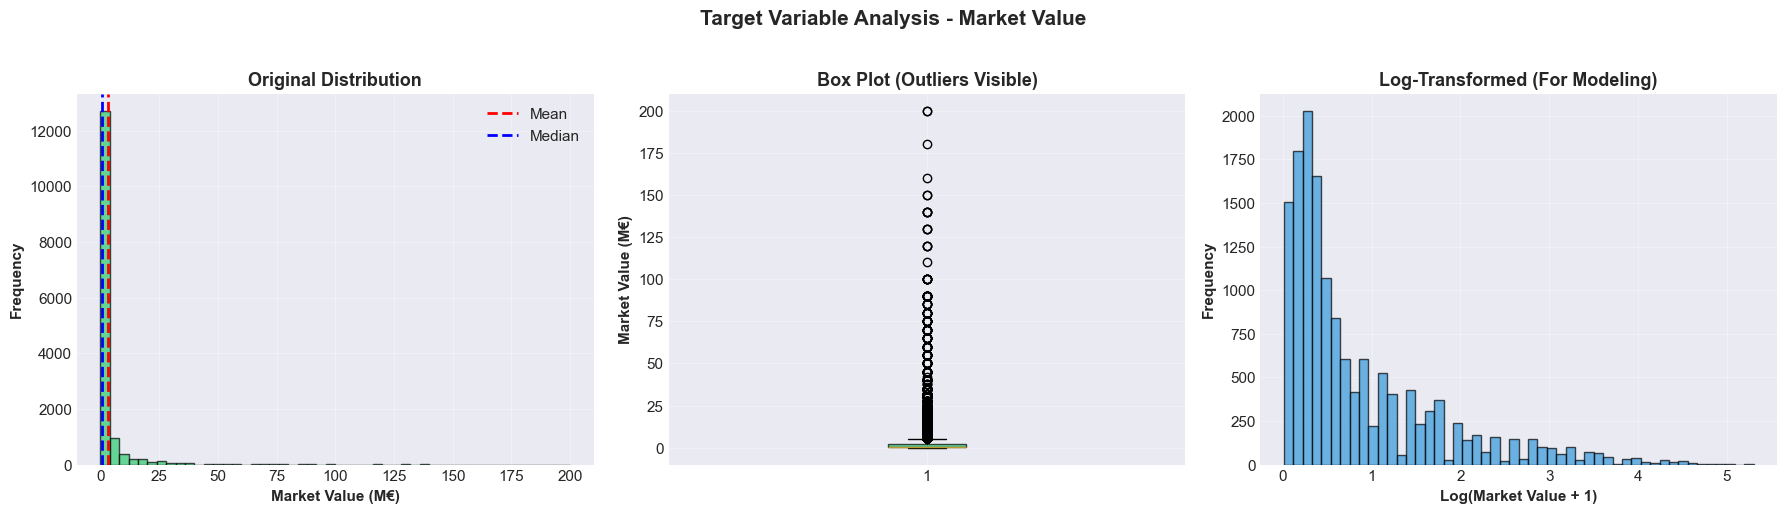

In [5]:
print("TARGET VARIABLE: MARKET_VALUE")

print(f"\nDistribution Metrics:")
print(f"   - Mean:     €{df['market_value'].mean():.2f}M")
print(f"   - Median:   €{df['market_value'].median():.2f}M")
print(f"   - Std Dev:  €{df['market_value'].std():.2f}M")
print(f"   - Skewness: {df['market_value'].skew():.4f}")
print(f"   - Kurtosis: {df['market_value'].kurtosis():.4f}")
print(f"   - Range:    €{df['market_value'].min():.2f}M - €{df['market_value'].max():.2f}M")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Original distribution
axes[0].hist(df['market_value'], bins=50, edgecolor='black', alpha=0.7, color='#2ecc71')
axes[0].axvline(df['market_value'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[0].axvline(df['market_value'].median(), color='blue', linestyle='--', linewidth=2, label='Median')
axes[0].set_xlabel('Market Value (M€)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0].set_title('Original Distribution', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot
bp = axes[1].boxplot(df['market_value'], vert=True, patch_artist=True)
bp['boxes'][0].set_facecolor('#2ecc71')
bp['boxes'][0].set_alpha(0.7)
axes[1].set_ylabel('Market Value (M€)', fontsize=11, fontweight='bold')
axes[1].set_title('Box Plot (Outliers Visible)', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3)

# Log-transformed
log_values = np.log1p(df['market_value'])
axes[2].hist(log_values, bins=50, edgecolor='black', alpha=0.7, color='#3498db')
axes[2].set_xlabel('Log(Market Value + 1)', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[2].set_title('Log-Transformed (For Modeling)', fontsize=13, fontweight='bold')
axes[2].grid(alpha=0.3)

plt.suptitle('Target Variable Analysis - Market Value', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_FOLDER, '01_target_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

---
## **3. Feature Engineering** <a id='3-feature-engineering'></a>

In [6]:
df_features = df.copy()
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

### **3.1 Biến đổi logarit cho các đặc trưng bị lệch (phân phối lệch) (Log Transformation)**

In [7]:
skewed_features = []
for col in numeric_cols:
    if col not in ['market_value', 'is_DF', 'is_MF', 'is_FW']:
        skewness = abs(df_features[col].skew())
        if skewness > 1.0:
            df_features[f'{col}_log'] = np.log1p(df_features[col])
            skewed_features.append(col)
print(f"   - {len(skewed_features)} features log-transformed")

   - 24 features log-transformed


### **3.2 Các tỷ lệ hiệu suất thi đấu (Performance Ratios)**

In [8]:
# Conversion rate
if 'goals_per_90' in df_features.columns and 'shots_per90' in df_features.columns:
    df_features['conversion_rate'] = df_features['goals_per_90'] / df_features['shots_per90'].replace(0, 0.01)
    print("   DONE: conversion_rate")

# Key pass ratio
if 'key_passes_per90' in df_features.columns and 'passes_completed_per90' in df_features.columns:
    df_features['key_pass_ratio'] = df_features['key_passes_per90'] / df_features['passes_completed_per90'].replace(0, 0.01)
    print("   DONE: key_pass_ratio")

# Defensive contribution
if all(col in df_features.columns for col in ['interceptions_per90', 'blocks_per90']):
    df_features['defensive_contribution'] = df_features['interceptions_per90'] + df_features['blocks_per90']
    print("   DONE: defensive_contribution")

# Total progressive actions
if all(col in df_features.columns for col in ['progressive_passes_per90', 'progressive_carries_per90']):
    df_features['total_progressive'] = df_features['progressive_passes_per90'] + df_features['progressive_carries_per90']
    print("   DONE: total_progressive")

   DONE: conversion_rate
   DONE: key_pass_ratio
   DONE: defensive_contribution
   DONE: total_progressive


### **3.3. Tạo đặc trưng tương tác**

In [9]:
# Age-Experience interaction
df_features['age_experience'] = df_features['age'] * np.log1p(df_features['minutes_played'])
print("   DONE: age_experience")

# Minutes per game
if 'minutes_played' in df_features.columns and 'appearances' in df_features.columns:
    df_features['minutes_per_game'] = df_features['minutes_played'] / df_features['appearances'].replace(0, 1)
    print("   DONE: minutes_per_game")

   DONE: age_experience
   DONE: minutes_per_game


### **3.4. Đặc trưng đa thức**

In [10]:
key_features = ['goals', 'assists', 'minutes_played']
for feat in key_features:
    if feat in df_features.columns:
        df_features[f'{feat}_squared'] = df_features[feat] ** 2
        print(f"   DONE: {feat}_squared")

   DONE: goals_squared
   DONE: assists_squared
   DONE: minutes_played_squared


### **3.5. Mã hóa đặc trưng phân loại**

In [11]:
categorical_cols = ['nationality', 'position', 'current_club', 'league']
temp_cols = ['calculated_mpg', 'calculated_sum']
df_features.drop(columns=[c for c in temp_cols if c in df_features.columns], inplace=True)

# Frequency encoding
for col in categorical_cols:
    if col in df_features.columns:
        freq = df_features[col].value_counts()
        df_features[f'{col}_freq'] = df_features[col].map(freq)
        print(f"   DONE: {col}: {df_features[col].nunique()} unique → freq encoded")

# Label encoding for league
le_league = LabelEncoder()
if 'league' in df_features.columns:
    df_features['league_label_enc'] = le_league.fit_transform(df_features['league'].astype(str))
    print(f"   DONE: league: label encoded")

print(f"\nFeature Engineering Complete!")
print(f"   - Total features: {len(df_features.columns)}")

   DONE: nationality: 162 unique → freq encoded
   DONE: current_club: 811 unique → freq encoded
   DONE: league: 57 unique → freq encoded
   DONE: league: label encoded

Feature Engineering Complete!
   - Total features: 78


---
## **4. Feature Selection** <a id='4-feature-selection'></a>

In [12]:
# Exclude columns
exclude_cols = ['market_value', 'position_category', 'nationality', 'position', 
                'current_club', 'league']
exclude_patterns = ['target_enc']

# Filter numeric features
feature_cols = [col for col in df_features.columns 
                if col not in exclude_cols 
                and df_features[col].dtype in ['int64', 'float64']
                and not any(pattern in col for pattern in exclude_patterns)]

print(f"\nFeature Filtering:")
print(f"   - Total columns: {len(df_features.columns)}")
print(f"   - Remaining numeric: {len(feature_cols)}")


Feature Filtering:
   - Total columns: 78
   - Remaining numeric: 73


In [13]:
# Calculate correlations with target
X_temp = df_features[feature_cols]
y_temp = df_features['market_value']

correlations = {}
for col in feature_cols:
    try:
        corr_value = abs(X_temp[col].corr(y_temp))
        correlations[col] = corr_value if not pd.isna(corr_value) else 0
    except:
        correlations[col] = 0

# Sort by correlation
sorted_corr = sorted(correlations.items(), key=lambda x: x[1], reverse=True)

print("\nTop 20 Features by Correlation with Target:")
for i, (feat, corr) in enumerate(sorted_corr[:20], 1):
    print(f"   {i:2d}. {feat:45s}: {corr:.4f}")


Top 20 Features by Correlation with Target:
    1. calculated_sum_log                           : 0.2716
    2. goals                                        : 0.2579
    3. goals_squared                                : 0.2493
    4. assists                                      : 0.2420
    5. goals_log                                    : 0.2201
    6. touches_att_pen_per90                        : 0.2198
    7. assists_log                                  : 0.2161
    8. assists_squared                              : 0.2159
    9. npg_per90_log                                : 0.2120
   10. npg_per90                                    : 0.2088
   11. minutes_played_squared                       : 0.2069
   12. passes_received_per90                        : 0.2062
   13. minutes_played                               : 0.2026
   14. gca_per90                                    : 0.1960
   15. appearances                                  : 0.1955
   16. gca_per90_log                    

In [14]:
# Select features with correlation > threshold
corr_threshold = 0.05
selected_features = [feat for feat, corr in correlations.items() if corr > corr_threshold]

# Add categorical columns for target encoding
categorical_to_encode = ['nationality', 'current_club']
final_features = selected_features + categorical_to_encode

print(f"\nFeature Selection Results:")
print(f"   - Threshold: |correlation| > {corr_threshold}")
print(f"   - Selected numeric: {len(selected_features)} features")
print(f"   - Categorical (to encode): {len(categorical_to_encode)}")
print(f"   - Total: {len(final_features)}")

# Save selected features
with open(os.path.join(ARTIFACT_FOLDER, 'selected_features.pkl'), 'wb') as f:
    pickle.dump(final_features, f)
print(f"\nSaved: selected_features.pkl")


Feature Selection Results:
   - Threshold: |correlation| > 0.05
   - Selected numeric: 60 features
   - Categorical (to encode): 2
   - Total: 62

Saved: selected_features.pkl


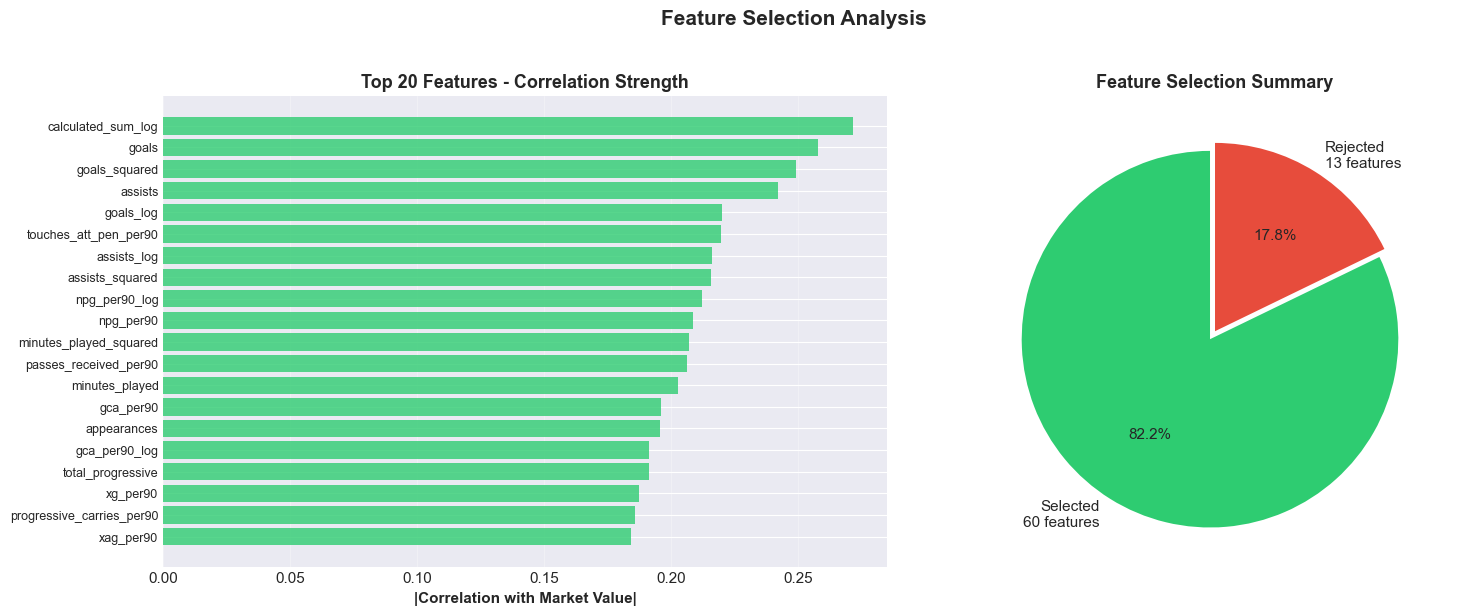

In [15]:
# Visualize Feature Selection
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 20 features bar chart
top_20_features = [feat for feat, _ in sorted_corr[:20]]
top_20_corr = [corr for _, corr in sorted_corr[:20]]

axes[0].barh(range(len(top_20_features)), top_20_corr, alpha=0.8, color='#2ecc71')
axes[0].set_yticks(range(len(top_20_features)))
axes[0].set_yticklabels(top_20_features, fontsize=9)
axes[0].set_xlabel('|Correlation with Market Value|', fontsize=11, fontweight='bold')
axes[0].set_title('Top 20 Features - Correlation Strength', fontsize=13, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(alpha=0.3, axis='x')

# Feature selection pie chart
selected_count = len(selected_features)
rejected_count = len(feature_cols) - selected_count
axes[1].pie([selected_count, rejected_count], 
            labels=[f'Selected\n{selected_count} features', f'Rejected\n{rejected_count} features'],
            autopct='%1.1f%%', startangle=90, colors=['#2ecc71', '#e74c3c'],
            explode=(0.05, 0))
axes[1].set_title('Feature Selection Summary', fontsize=13, fontweight='bold')

plt.suptitle('Feature Selection Analysis', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_FOLDER, '02_feature_selection.png'), dpi=300, bbox_inches='tight')
plt.show()

---
## **5. Data Preparation** <a id='5-preprocessing'></a>

In [16]:
# Load selected features
with open(os.path.join(ARTIFACT_FOLDER, 'selected_features.pkl'), 'rb') as f:
    selected_features = pickle.load(f)


### **5.1 Loại bỏ Outlier**

In [17]:
print("\nOutlier Removal (1% - 99% percentile):")
Q1 = df_features['market_value'].quantile(0.01)
Q3 = df_features['market_value'].quantile(0.99)
df_clean = df_features[(df_features['market_value'] >= Q1) & 
                        (df_features['market_value'] <= Q3)].copy()

print(f"   - Original:  {len(df_features):,} samples")
print(f"   - Cleaned:   {len(df_clean):,} samples ({len(df_clean)/len(df_features)*100:.1f}%)")
print(f"   - Removed:   {len(df_features) - len(df_clean):,} outliers")


Outlier Removal (1% - 99% percentile):
   - Original:  14,977 samples
   - Cleaned:   14,823 samples (99.0%)
   - Removed:   154 outliers


### **5.2 Chuẩn bị đặc trưng và mục tiêu**

In [18]:
X_raw = df_clean[selected_features]
y = df_clean['market_value']
y_log = np.log1p(y)  # Log transform target

print(f"   - Total features: {X_raw.shape[1]}")
print(f"   - Samples: {X_raw.shape[0]:,}")
print(f"   - Target transformed: log1p(market_value)")

   - Total features: 62
   - Samples: 14,823
   - Target transformed: log1p(market_value)


### **5.3 Phân chia tập dữ liệu**

In [19]:
print("\nData Split (64% / 16% / 20%):")

# First split: 80% temp, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_raw, y_log, test_size=0.2, random_state=42, shuffle=True
)

# Second split: 80% train, 20% validation (of temp)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, shuffle=True
)

print(f"   - Training:   {len(X_train):,} ({len(X_train)/len(X_raw)*100:.1f}%)")
print(f"   - Validation: {len(X_val):,} ({len(X_val)/len(X_raw)*100:.1f}%)")
print(f"   - Test:       {len(X_test):,} ({len(X_test)/len(X_raw)*100:.1f}%)")


Data Split (64% / 16% / 20%):
   - Training:   9,486 (64.0%)
   - Validation: 2,372 (16.0%)
   - Test:       2,965 (20.0%)


### **5.4 Mã hóa mục tiêu cho biến phân loại (với K-Fold để ngăn chặn rò rỉ dữ liệu)**

In [20]:
def target_encode(X_train, y_train, X_val, X_test, column, n_folds=5):
    """Apply target encoding with K-Fold to prevent data leakage."""
    X_train = X_train.copy()
    X_val = X_val.copy()
    X_test = X_test.copy()
    
    new_col = f'{column}_target_enc'
    X_train[new_col] = np.nan
    
    # Out-of-fold encoding
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    train_indices = X_train.index.to_numpy()
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        actual_train_idx = train_indices[train_idx]
        actual_val_idx = train_indices[val_idx]
        
        X_fold_train = X_train.loc[actual_train_idx]
        y_fold_train = y_train.loc[actual_train_idx]
        
        temp_df = pd.DataFrame({'category': X_fold_train[column], 'target': y_fold_train})
        means = temp_df.groupby('category')['target'].mean()
        
        X_fold_val = X_train.loc[actual_val_idx]
        encoded = X_fold_val[column].map(means)
        X_train.loc[actual_val_idx, new_col] = encoded
    
    # Fill NaN with overall mean
    overall_mean = y_train.mean()
    X_train[new_col].fillna(overall_mean, inplace=True)
    
    # Encode validation and test using full training set
    temp_df_full = pd.DataFrame({'category': X_train[column], 'target': y_train})
    global_means = temp_df_full.groupby('category')['target'].mean()
    
    X_val[new_col] = X_val[column].map(global_means).fillna(overall_mean)
    X_test[new_col] = X_test[column].map(global_means).fillna(overall_mean)
    
    # Drop original column
    X_train = X_train.drop(columns=[column])
    X_val = X_val.drop(columns=[column])
    X_test = X_test.drop(columns=[column])
    
    corr = X_train[new_col].corr(y_train)
    print(f"   - {column}: {len(global_means)} categories → encoded (corr: {corr:.4f})")
    
    return X_train, X_val, X_test

# Apply target encoding
categorical_cols_to_encode = ['nationality', 'current_club']
for col in categorical_cols_to_encode:
    if col in X_train.columns:
        X_train, X_val, X_test = target_encode(
            X_train, y_train, X_val, X_test, column=col, n_folds=5
        )

   - nationality: 155 categories → encoded (corr: 0.3598)
   - current_club: 793 categories → encoded (corr: 0.7104)


### **5.5. Handle Missing Values**

In [21]:
imputer = SimpleImputer(strategy='constant', fill_value=0)
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)
X_test_imputed = imputer.transform(X_test)

feature_names = X_train.columns.tolist()
X_train_final = pd.DataFrame(X_train_imputed, columns=feature_names, index=X_train.index)
X_val_final = pd.DataFrame(X_val_imputed, columns=feature_names, index=X_val.index)
X_test_final = pd.DataFrame(X_test_imputed, columns=feature_names, index=X_test.index)

print(f"   - Strategy: Fill with 0")
print(f"   - Missing values remaining: {X_train_final.isnull().sum().sum()}")

   - Strategy: Fill with 0
   - Missing values remaining: 0


In [22]:
# Summary
print("\n" + "="*70)
print("DATA PREPROCESSING SUMMARY")
print("="*70)
print(f"\n- Ready datasets:")
print(f"   - X_train_final (unscaled): {X_train_final.shape}")
print(f"   - X_val_final/scaled:       {X_val_final.shape}")
print(f"   - X_test_final/scaled:      {X_test_final.shape}")
print(f"   - y_train/val/test:         Log-transformed target")
print(f"\n- Features: {len(feature_names)}")


DATA PREPROCESSING SUMMARY

- Ready datasets:
   - X_train_final (unscaled): (9486, 62)
   - X_val_final/scaled:       (2372, 62)
   - X_test_final/scaled:      (2965, 62)
   - y_train/val/test:         Log-transformed target

- Features: 62


---
## **6. Model 1: Random Forest** <a id='6-random-forest'></a>

In [23]:
print("="*70)
print("MODEL 1: RANDOM FOREST REGRESSOR")
print("="*70)

MODEL 1: RANDOM FOREST REGRESSOR


### **6.1 Baseline Model**

In [24]:
rf_baseline = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features=0.5,
    min_weight_fraction_leaf=0.01,
    ccp_alpha=0.0001,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

print(f"\nHyperparameters:")
print(f"   - n_estimators:        {rf_baseline.n_estimators}")
print(f"   - max_depth:           {rf_baseline.max_depth}")
print(f"   - min_samples_split:   {rf_baseline.min_samples_split}")
print(f"   - min_samples_leaf:    {rf_baseline.min_samples_leaf}")
print(f"   - max_features:        {rf_baseline.max_features}")

# Train
rf_start = time.time()
rf_baseline.fit(X_train_final, y_train)
rf_train_time = time.time() - rf_start
print(f"\nDone: Training completed in {rf_train_time:.2f}s")


Hyperparameters:
   - n_estimators:        200
   - max_depth:           20
   - min_samples_split:   10
   - min_samples_leaf:    5
   - max_features:        0.5

Done: Training completed in 1.97s


In [25]:
# Baseline Evaluation
print("\nBaseline Model Evaluation:")

# Predictions
y_train_pred_rf = rf_baseline.predict(X_train_final)
y_val_pred_rf = rf_baseline.predict(X_val_final)
y_test_pred_rf = rf_baseline.predict(X_test_final)

# Convert back to original scale
y_train_pred_rf_orig = np.expm1(y_train_pred_rf)
y_val_pred_rf_orig = np.expm1(y_val_pred_rf)
y_test_pred_rf_orig = np.expm1(y_test_pred_rf)
y_train_orig = np.expm1(y_train)
y_val_orig = np.expm1(y_val)
y_test_orig = np.expm1(y_test)

# Metrics
rf_baseline_train_r2 = r2_score(y_train, y_train_pred_rf)
rf_baseline_val_r2 = r2_score(y_val, y_val_pred_rf)
rf_baseline_test_r2 = r2_score(y_test, y_test_pred_rf)
rf_baseline_test_mse = mean_squared_error(y_test_orig, y_test_pred_rf_orig)
rf_baseline_test_rmse = np.sqrt(rf_baseline_test_mse)
rf_baseline_test_mae = mean_absolute_error(y_test_orig, y_test_pred_rf_orig)

print(f"\n   Train R²:      {rf_baseline_train_r2:.4f}")
print(f"   Validation R²: {rf_baseline_val_r2:.4f}")
print(f"   Test R²:       {rf_baseline_test_r2:.4f}")
print(f"   Test MSE:      €{rf_baseline_test_mse:.2f}M²")
print(f"   Test RMSE:     €{rf_baseline_test_rmse:.2f}M")
print(f"   Test MAE:      €{rf_baseline_test_mae:.2f}M")
print(f"\n   Train-Test Gap: {rf_baseline_train_r2 - rf_baseline_test_r2:.4f}")


Baseline Model Evaluation:

   Train R²:      0.7367
   Validation R²: 0.7025
   Test R²:       0.7117
   Test MSE:      €18.09M²
   Test RMSE:     €4.25M
   Test MAE:      €1.62M

   Train-Test Gap: 0.0250


### **6.2 Cross-Validation**

In [26]:
print("\nCross-Validation (5-Fold):")

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
rf_cv_scores = cross_val_score(
    rf_baseline, X_train_final, y_train,
    cv=kfold, scoring='r2', n_jobs=-1
)

print(f"\n   Fold scores: {[f'{s:.4f}' for s in rf_cv_scores]}")
print(f"   Mean R²:     {rf_cv_scores.mean():.4f} ± {rf_cv_scores.std():.4f}")

if rf_cv_scores.std() < 0.02:
    print(f"   Status:      Excellent stability (std < 0.02)")
elif rf_cv_scores.std() < 0.05:
    print(f"   Status:      Good stability (std < 0.05)")
else:
    print(f"   Status:      High variance - consider regularization")


Cross-Validation (5-Fold):

   Fold scores: ['0.6893', '0.7245', '0.7016', '0.7176', '0.7013']
   Mean R²:     0.7069 ± 0.0126
   Status:      Excellent stability (std < 0.02)


### **6.3 Hyperparameter Tuning (GridSearchCV)**

In [27]:
rf_param_grid = {
    'n_estimators': [150, 200, 250],
    'max_depth': [15, 20, 25],
    'min_samples_split': [5, 7, 10],
    'min_samples_leaf': [3, 5, 7],
    'max_features': [0.5, 0.6, 0.7]
}

print(f"\nParameter Grid:")
for param, values in rf_param_grid.items():
    print(f"   - {param}: {values}")

total_combinations = np.prod([len(v) for v in rf_param_grid.values()])
print(f"\nTotal combinations: {total_combinations}")
print(f"With 5-fold CV: {total_combinations * 5} fits")


Parameter Grid:
   - n_estimators: [150, 200, 250]
   - max_depth: [15, 20, 25]
   - min_samples_split: [5, 7, 10]
   - min_samples_leaf: [3, 5, 7]
   - max_features: [0.5, 0.6, 0.7]

Total combinations: 243
With 5-fold CV: 1215 fits


In [28]:
# Run GridSearchCV
rf_base = RandomForestRegressor(
    random_state=42, n_jobs=-1,
    min_weight_fraction_leaf=0.01,
    ccp_alpha=0.0001
)

rf_grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=rf_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

print("\nStarting GridSearchCV...")
rf_tune_start = time.time()
rf_grid_search.fit(X_train_final, y_train)
rf_tune_time = time.time() - rf_tune_start
print(f"\nCompleted in {rf_tune_time:.2f}s ({rf_tune_time/60:.2f} min)")


Starting GridSearchCV...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits

Completed in 1980.93s (33.02 min)


In [29]:
# Best parameters
print(f"\nBest Parameters:")
for param, value in rf_grid_search.best_params_.items():
    print(f"   - {param}: {value}")
print(f"\nBest CV R²: {rf_grid_search.best_score_:.4f}")


Best Parameters:
   - max_depth: 15
   - max_features: 0.7
   - min_samples_leaf: 3
   - min_samples_split: 5
   - n_estimators: 250

Best CV R²: 0.7104


### **6.4 Final Model Evaluation**

In [30]:
rf_tuned = rf_grid_search.best_estimator_

# Predictions
y_train_pred_rf_tuned = rf_tuned.predict(X_train_final)
y_val_pred_rf_tuned = rf_tuned.predict(X_val_final)
y_test_pred_rf_tuned = rf_tuned.predict(X_test_final)

# Convert to original scale
y_train_pred_rf_tuned_orig = np.expm1(y_train_pred_rf_tuned)
y_val_pred_rf_tuned_orig = np.expm1(y_val_pred_rf_tuned)
y_test_pred_rf_tuned_orig = np.expm1(y_test_pred_rf_tuned)

# Metrics
rf_train_r2 = r2_score(y_train, y_train_pred_rf_tuned)
rf_val_r2 = r2_score(y_val, y_val_pred_rf_tuned)
rf_test_r2 = r2_score(y_test, y_test_pred_rf_tuned)
rf_test_mse = mean_squared_error(y_test_orig, y_test_pred_rf_tuned_orig)
rf_test_rmse = np.sqrt(rf_test_mse)
rf_test_mae = mean_absolute_error(y_test_orig, y_test_pred_rf_tuned_orig)

# MAPE
mask = y_test_orig > 0.1
rf_test_mape = np.mean(np.abs((y_test_orig[mask] - y_test_pred_rf_tuned_orig[mask]) / y_test_orig[mask])) * 100

print(f"\n   Train R²:      {rf_train_r2:.4f}")
print(f"   Validation R²: {rf_val_r2:.4f}")
print(f"   Test R²:       {rf_test_r2:.4f}")
print(f"   Test MSE:      €{rf_test_mse:.2f}M²")
print(f"   Test RMSE:     €{rf_test_rmse:.2f}M")
print(f"   Test MAE:      €{rf_test_mae:.2f}M")
print(f"   Test MAPE:     {rf_test_mape:.2f}%")
print(f"\n   Train-Test Gap: {rf_train_r2 - rf_test_r2:.4f}")

# Improvement
rf_r2_improvement = (rf_test_r2 - rf_baseline_test_r2) / rf_baseline_test_r2 * 100
print(f"\n   Improvement over baseline: {rf_r2_improvement:+.2f}%")


   Train R²:      0.7391
   Validation R²: 0.7013
   Test R²:       0.7118
   Test MSE:      €17.40M²
   Test RMSE:     €4.17M
   Test MAE:      €1.60M
   Test MAPE:     83.31%

   Train-Test Gap: 0.0273

   Improvement over baseline: +0.02%


In [31]:
# Save RF results
rf_results = {
    'model_name': 'Random Forest',
    'best_params': rf_grid_search.best_params_,
    'cv_score': rf_grid_search.best_score_,
    'train_r2': rf_train_r2,
    'val_r2': rf_val_r2,
    'test_r2': rf_test_r2,
    'test_mse': rf_test_mse,
    'test_rmse': rf_test_rmse,
    'test_mae': rf_test_mae,
    'test_mape': rf_test_mape,
    'train_time': rf_train_time,
    'tune_time': rf_tune_time
}

# Save model
joblib.dump(rf_tuned, os.path.join(MODEL_FOLDER, 'RF_final_model.pkl'))
print("\nRandom Forest model saved!")


Random Forest model saved!


---
## **7. Model 2: XGBoost** <a id='7-xgboost'></a>

In [32]:
print("="*70)
print("MODEL 2: XGBOOST REGRESSOR")
print("="*70)

MODEL 2: XGBOOST REGRESSOR


### **7.1 Baseline Model**

In [33]:
xgb_baseline = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0,
    reg_alpha=0,
    reg_lambda=1,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

print(f"\nHyperparameters:")
print(f"   - n_estimators:     {xgb_baseline.n_estimators}")
print(f"   - learning_rate:    {xgb_baseline.learning_rate}")
print(f"   - max_depth:        {xgb_baseline.max_depth}")
print(f"   - min_child_weight: {xgb_baseline.min_child_weight}")
print(f"   - subsample:        {xgb_baseline.subsample}")

# Train
xgb_start = time.time()
xgb_baseline.fit(
    X_train_final, y_train,
    eval_set=[(X_train_final, y_train), (X_val_final, y_val)],
    verbose=False
)
xgb_train_time = time.time() - xgb_start
print(f"\nTraining completed in {xgb_train_time:.2f}s")


Hyperparameters:
   - n_estimators:     200
   - learning_rate:    0.05
   - max_depth:        6
   - min_child_weight: 3
   - subsample:        0.8

Training completed in 1.94s


In [34]:
# Baseline Evaluation
print("\nBaseline Model Evaluation:")

y_train_pred_xgb = xgb_baseline.predict(X_train_final)
y_val_pred_xgb = xgb_baseline.predict(X_val_final)
y_test_pred_xgb = xgb_baseline.predict(X_test_final)

xgb_baseline_train_r2 = r2_score(y_train, y_train_pred_xgb)
xgb_baseline_val_r2 = r2_score(y_val, y_val_pred_xgb)
xgb_baseline_test_r2 = r2_score(y_test, y_test_pred_xgb)
xgb_baseline_test_rmse = np.sqrt(mean_squared_error(y_test_orig, np.expm1(y_test_pred_xgb)))
xgb_baseline_test_mae = mean_absolute_error(y_test_orig, np.expm1(y_test_pred_xgb))

print(f"\n   Train R²:      {xgb_baseline_train_r2:.4f}")
print(f"   Validation R²: {xgb_baseline_val_r2:.4f}")
print(f"   Test R²:       {xgb_baseline_test_r2:.4f}")
print(f"   Test RMSE:     €{xgb_baseline_test_rmse:.2f}M")
print(f"   Test MAE:      €{xgb_baseline_test_mae:.2f}M")


Baseline Model Evaluation:

   Train R²:      0.8988
   Validation R²: 0.7546
   Test R²:       0.7682
   Test RMSE:     €3.35M
   Test MAE:      €1.32M


### **7.2 Cross-Validation**

In [35]:
print("\nCross-Validation (5-Fold):")

xgb_cv_scores = cross_val_score(
    xgb_baseline, X_train_final, y_train,
    cv=kfold, scoring='r2', n_jobs=-1
)

print(f"\n   Fold scores: {[f'{s:.4f}' for s in xgb_cv_scores]}")
print(f"   Mean R²:     {xgb_cv_scores.mean():.4f} ± {xgb_cv_scores.std():.4f}")


Cross-Validation (5-Fold):

   Fold scores: ['0.7210', '0.7739', '0.7536', '0.7678', '0.7554']
   Mean R²:     0.7543 ± 0.0183


### **7.3 Hyperparameter Tuning (GridSearchCV)**

In [36]:
xgb_param_grid = {
    'n_estimators': [200, 300, 400],
    'learning_rate': [0.03, 0.05, 0.07],
    'max_depth': [5, 6, 7],
    'min_child_weight': [2, 3, 4],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

print(f"\nParameter Grid:")
for param, values in xgb_param_grid.items():
    print(f"   - {param}: {values}")

total_combinations = np.prod([len(v) for v in xgb_param_grid.values()])
print(f"\nTotal combinations: {total_combinations}")


Parameter Grid:
   - n_estimators: [200, 300, 400]
   - learning_rate: [0.03, 0.05, 0.07]
   - max_depth: [5, 6, 7]
   - min_child_weight: [2, 3, 4]
   - subsample: [0.7, 0.8, 0.9]
   - colsample_bytree: [0.7, 0.8, 0.9]

Total combinations: 729


In [37]:
# Run GridSearchCV
xgb_grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(random_state=42, n_jobs=-1, verbosity=0),
    param_grid=xgb_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

print("\nStarting GridSearchCV...")
xgb_tune_start = time.time()
xgb_grid_search.fit(X_train_final, y_train)
xgb_tune_time = time.time() - xgb_tune_start
print(f"\nCompleted in {xgb_tune_time:.2f}s ({xgb_tune_time/60:.2f} min)")


Starting GridSearchCV...
Fitting 5 folds for each of 729 candidates, totalling 3645 fits

Completed in 2325.50s (38.76 min)


In [38]:
# Best parameters
print(f"\nBest Parameters:")
for param, value in xgb_grid_search.best_params_.items():
    print(f"   - {param}: {value}")
print(f"\nBest CV R²: {xgb_grid_search.best_score_:.4f}")


Best Parameters:
   - colsample_bytree: 0.7
   - learning_rate: 0.03
   - max_depth: 7
   - min_child_weight: 4
   - n_estimators: 400
   - subsample: 0.7

Best CV R²: 0.7604


### **7.4 Final Model Evaluation**

In [39]:
xgb_tuned = xgb_grid_search.best_estimator_

# Predictions
y_train_pred_xgb_tuned = xgb_tuned.predict(X_train_final)
y_val_pred_xgb_tuned = xgb_tuned.predict(X_val_final)
y_test_pred_xgb_tuned = xgb_tuned.predict(X_test_final)

# Convert to original scale
y_test_pred_xgb_tuned_orig = np.expm1(y_test_pred_xgb_tuned)

# Metrics
xgb_train_r2 = r2_score(y_train, y_train_pred_xgb_tuned)
xgb_val_r2 = r2_score(y_val, y_val_pred_xgb_tuned)
xgb_test_r2 = r2_score(y_test, y_test_pred_xgb_tuned)
xgb_test_mse = mean_squared_error(y_test_orig, y_test_pred_xgb_tuned_orig)
xgb_test_rmse = np.sqrt(xgb_test_mse)
xgb_test_mae = mean_absolute_error(y_test_orig, y_test_pred_xgb_tuned_orig)

# MAPE
xgb_test_mape = np.mean(np.abs((y_test_orig[mask] - y_test_pred_xgb_tuned_orig[mask]) / y_test_orig[mask])) * 100

print(f"\n   Train R²:      {xgb_train_r2:.4f}")
print(f"   Validation R²: {xgb_val_r2:.4f}")
print(f"   Test R²:       {xgb_test_r2:.4f}")
print(f"   Test MSE:      €{xgb_test_mse:.2f}M²")
print(f"   Test RMSE:     €{xgb_test_rmse:.2f}M")
print(f"   Test MAE:      €{xgb_test_mae:.2f}M")
print(f"   Test MAPE:     {xgb_test_mape:.2f}%")
print(f"\n   Train-Test Gap: {xgb_train_r2 - xgb_test_r2:.4f}")

# Improvement
xgb_r2_improvement = (xgb_test_r2 - xgb_baseline_test_r2) / xgb_baseline_test_r2 * 100
print(f"\n   Improvement over baseline: {xgb_r2_improvement:+.2f}%")


   Train R²:      0.9360
   Validation R²: 0.7553
   Test R²:       0.7716
   Test MSE:      €11.44M²
   Test RMSE:     €3.38M
   Test MAE:      €1.32M
   Test MAPE:     72.65%

   Train-Test Gap: 0.1644

   Improvement over baseline: +0.44%


In [40]:
# Save XGB results
xgb_results = {
    'model_name': 'XGBoost',
    'best_params': xgb_grid_search.best_params_,
    'cv_score': xgb_grid_search.best_score_,
    'train_r2': xgb_train_r2,
    'val_r2': xgb_val_r2,
    'test_r2': xgb_test_r2,
    'test_mse': xgb_test_mse,
    'test_rmse': xgb_test_rmse,
    'test_mae': xgb_test_mae,
    'test_mape': xgb_test_mape,
    'train_time': xgb_train_time,
    'tune_time': xgb_tune_time
}

# Save model
joblib.dump(xgb_tuned, os.path.join(MODEL_FOLDER, 'XGB_final_model.pkl'))
print("\nXGBoost model saved!")


XGBoost model saved!


---
## **8. Model 3: LightGBM** <a id='8-lightgbm'></a>

In [41]:
print("="*70)
print("MODEL 3: LIGHTGBM REGRESSOR")
print("="*70)

MODEL 3: LIGHTGBM REGRESSOR


### **8.1 Baseline Model**

In [42]:
lgb_baseline = lgb.LGBMRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    num_leaves=31,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

print(f"\nHyperparameters:")
print(f"   - n_estimators:      {lgb_baseline.n_estimators}")
print(f"   - learning_rate:     {lgb_baseline.learning_rate}")
print(f"   - max_depth:         {lgb_baseline.max_depth}")
print(f"   - num_leaves:        {lgb_baseline.num_leaves}")
print(f"   - min_child_samples: {lgb_baseline.min_child_samples}")

# Train
lgb_start = time.time()
lgb_baseline.fit(X_train_final, y_train)
lgb_train_time = time.time() - lgb_start
print(f"\nTraining completed in {lgb_train_time:.2f}s")


Hyperparameters:
   - n_estimators:      200
   - learning_rate:     0.05
   - max_depth:         6
   - num_leaves:        31
   - min_child_samples: 20

Training completed in 0.67s


In [43]:
# Baseline Evaluation
print("\nBaseline Model Evaluation:")

y_train_pred_lgb = lgb_baseline.predict(X_train_final)
y_val_pred_lgb = lgb_baseline.predict(X_val_final)
y_test_pred_lgb = lgb_baseline.predict(X_test_final)

lgb_baseline_train_r2 = r2_score(y_train, y_train_pred_lgb)
lgb_baseline_val_r2 = r2_score(y_val, y_val_pred_lgb)
lgb_baseline_test_r2 = r2_score(y_test, y_test_pred_lgb)
lgb_baseline_test_rmse = np.sqrt(mean_squared_error(y_test_orig, np.expm1(y_test_pred_lgb)))
lgb_baseline_test_mae = mean_absolute_error(y_test_orig, np.expm1(y_test_pred_lgb))

print(f"\n   Train R²:      {lgb_baseline_train_r2:.4f}")
print(f"   Validation R²: {lgb_baseline_val_r2:.4f}")
print(f"   Test R²:       {lgb_baseline_test_r2:.4f}")
print(f"   Test RMSE:     €{lgb_baseline_test_rmse:.2f}M")
print(f"   Test MAE:      €{lgb_baseline_test_mae:.2f}M")


Baseline Model Evaluation:

   Train R²:      0.8619
   Validation R²: 0.7573
   Test R²:       0.7659
   Test RMSE:     €3.38M
   Test MAE:      €1.33M


### **8.2 Cross-Validation**

In [44]:
print("\nCross-Validation (5-Fold):")

lgb_cv_scores = cross_val_score(
    lgb_baseline, X_train_final, y_train,
    cv=kfold, scoring='r2', n_jobs=-1
)

print(f"\n   Fold scores: {[f'{s:.4f}' for s in lgb_cv_scores]}")
print(f"   Mean R²:     {lgb_cv_scores.mean():.4f} ± {lgb_cv_scores.std():.4f}")


Cross-Validation (5-Fold):

   Fold scores: ['0.7276', '0.7714', '0.7607', '0.7712', '0.7521']
   Mean R²:     0.7566 ± 0.0162


### **8.3 Hyperparameter Tuning (GridSearchCV)**

In [45]:
lgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 6, 9],
    'num_leaves': [15, 31, 63],
    'min_child_samples': [10, 20, 30]
}

print(f"\nParameter Grid:")
for param, values in lgb_param_grid.items():
    print(f"   - {param}: {values}")

total_combinations = np.prod([len(v) for v in lgb_param_grid.values()])
print(f"\nTotal combinations: {total_combinations}")


Parameter Grid:
   - n_estimators: [100, 200, 300]
   - learning_rate: [0.01, 0.05, 0.1]
   - max_depth: [3, 6, 9]
   - num_leaves: [15, 31, 63]
   - min_child_samples: [10, 20, 30]

Total combinations: 243


In [46]:
# Run GridSearchCV
lgb_base = lgb.LGBMRegressor(
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

lgb_grid_search = GridSearchCV(
    estimator=lgb_base,
    param_grid=lgb_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

print("\nStarting GridSearchCV...")
lgb_tune_start = time.time()
lgb_grid_search.fit(X_train_final, y_train)
lgb_tune_time = time.time() - lgb_tune_start
print(f"\nCompleted in {lgb_tune_time:.2f}s ({lgb_tune_time/60:.2f} min)")


Starting GridSearchCV...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits

Completed in 424.93s (7.08 min)


In [47]:
# Best parameters
print(f"\nBest Parameters:")
for param, value in lgb_grid_search.best_params_.items():
    print(f"   - {param}: {value}")
print(f"\nBest CV R²: {lgb_grid_search.best_score_:.4f}")


Best Parameters:
   - learning_rate: 0.05
   - max_depth: 6
   - min_child_samples: 30
   - n_estimators: 300
   - num_leaves: 31

Best CV R²: 0.7574


### **8.4 Final Model Evaluation**

In [48]:
lgb_tuned = lgb_grid_search.best_estimator_

# Predictions
y_train_pred_lgb_tuned = lgb_tuned.predict(X_train_final)
y_val_pred_lgb_tuned = lgb_tuned.predict(X_val_final)
y_test_pred_lgb_tuned = lgb_tuned.predict(X_test_final)

# Convert to original scale
y_test_pred_lgb_tuned_orig = np.expm1(y_test_pred_lgb_tuned)

# Metrics
lgb_train_r2 = r2_score(y_train, y_train_pred_lgb_tuned)
lgb_val_r2 = r2_score(y_val, y_val_pred_lgb_tuned)
lgb_test_r2 = r2_score(y_test, y_test_pred_lgb_tuned)
lgb_test_mse = mean_squared_error(y_test_orig, y_test_pred_lgb_tuned_orig)
lgb_test_rmse = np.sqrt(lgb_test_mse)
lgb_test_mae = mean_absolute_error(y_test_orig, y_test_pred_lgb_tuned_orig)

# MAPE
lgb_test_mape = np.mean(np.abs((y_test_orig[mask] - y_test_pred_lgb_tuned_orig[mask]) / y_test_orig[mask])) * 100

print(f"\n   Train R²:      {lgb_train_r2:.4f}")
print(f"   Validation R²: {lgb_val_r2:.4f}")
print(f"   Test R²:       {lgb_test_r2:.4f}")
print(f"   Test MSE:      €{lgb_test_mse:.2f}M²")
print(f"   Test RMSE:     €{lgb_test_rmse:.2f}M")
print(f"   Test MAE:      €{lgb_test_mae:.2f}M")
print(f"   Test MAPE:     {lgb_test_mape:.2f}%")
print(f"\n   Train-Test Gap: {lgb_train_r2 - lgb_test_r2:.4f}")

# Improvement
lgb_r2_improvement = (lgb_test_r2 - lgb_baseline_test_r2) / lgb_baseline_test_r2 * 100
print(f"\n   Improvement over baseline: {lgb_r2_improvement:+.2f}%")


   Train R²:      0.8764
   Validation R²: 0.7565
   Test R²:       0.7690
   Test MSE:      €11.07M²
   Test RMSE:     €3.33M
   Test MAE:      €1.31M
   Test MAPE:     71.27%

   Train-Test Gap: 0.1073

   Improvement over baseline: +0.41%


In [49]:
# Save LGB results
lgb_results = {
    'model_name': 'LightGBM',
    'best_params': lgb_grid_search.best_params_,
    'cv_score': lgb_grid_search.best_score_,
    'train_r2': lgb_train_r2,
    'val_r2': lgb_val_r2,
    'test_r2': lgb_test_r2,
    'test_mse': lgb_test_mse,
    'test_rmse': lgb_test_rmse,
    'test_mae': lgb_test_mae,
    'test_mape': lgb_test_mape,
    'train_time': lgb_train_time,
    'tune_time': lgb_tune_time
}

# Save model
joblib.dump(lgb_tuned, os.path.join(MODEL_FOLDER, 'LGB_final_model.pkl'))
print("\nLightGBM model saved!")


LightGBM model saved!


---
## **9. Model Comparison & Benchmarking** <a id='9-comparison'></a>

In [50]:
print("="*70)
print("MODEL COMPARISON & BENCHMARKING")
print("="*70)

MODEL COMPARISON & BENCHMARKING


### **9.1 Performance Metrics Comparison Table**

In [51]:
# Create comparison DataFrame
comparison_data = {
    'Model': ['Random Forest', 'XGBoost', 'LightGBM'],
    'CV R² (5-Fold)': [rf_grid_search.best_score_, xgb_grid_search.best_score_, lgb_grid_search.best_score_],
    'Train R²': [rf_train_r2, xgb_train_r2, lgb_train_r2],
    'Validation R²': [rf_val_r2, xgb_val_r2, lgb_val_r2],
    'Test R²': [rf_test_r2, xgb_test_r2, lgb_test_r2],
    'Test MSE (€M²)': [rf_test_mse, xgb_test_mse, lgb_test_mse],
    'Test RMSE (€M)': [rf_test_rmse, xgb_test_rmse, lgb_test_rmse],
    'Test MAE (€M)': [rf_test_mae, xgb_test_mae, lgb_test_mae],
    'Test MAPE (%)': [rf_test_mape, xgb_test_mape, lgb_test_mape],
    'Train-Test Gap': [rf_train_r2 - rf_test_r2, xgb_train_r2 - xgb_test_r2, lgb_train_r2 - lgb_test_r2],
    'Training Time (s)': [rf_train_time, xgb_train_time, lgb_train_time],
    'Tuning Time (s)': [rf_tune_time, xgb_tune_time, lgb_tune_time]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.set_index('Model')

print("\nMODEL PERFORMANCE COMPARISON TABLE")
print("="*70)
print(comparison_df.to_string())


MODEL PERFORMANCE COMPARISON TABLE
               CV R² (5-Fold)  Train R²  Validation R²   Test R²  Test MSE (€M²)  Test RMSE (€M)  Test MAE (€M)  Test MAPE (%)  Train-Test Gap  Training Time (s)  Tuning Time (s)
Model                                                                                                                                                                             
Random Forest        0.710423  0.739127       0.701285  0.711847       17.399156        4.171230       1.597837      83.306496        0.027279           1.968164      1980.926075
XGBoost              0.760409  0.935982       0.755333  0.771628       11.437941        3.382003       1.318214      72.646491        0.164354           1.943986      2325.502885
LightGBM             0.757365  0.876350       0.756535  0.769026       11.072279        3.327503       1.306137      71.274283        0.107324           0.668416       424.933672


In [52]:
# Styled comparison table
print("\nFormatted Comparison:")
print("\n" + "-"*90)
print(f"{'Metric':<25} {'Random Forest':>18} {'XGBoost':>18} {'LightGBM':>18}")
print("-"*90)
print(f"{'CV R² (5-Fold)':<25} {rf_grid_search.best_score_:>18.4f} {xgb_grid_search.best_score_:>18.4f} {lgb_grid_search.best_score_:>18.4f}")
print(f"{'Train R²':<25} {rf_train_r2:>18.4f} {xgb_train_r2:>18.4f} {lgb_train_r2:>18.4f}")
print(f"{'Validation R²':<25} {rf_val_r2:>18.4f} {xgb_val_r2:>18.4f} {lgb_val_r2:>18.4f}")
print(f"{'Test R²':<25} {rf_test_r2:>18.4f} {xgb_test_r2:>18.4f} {lgb_test_r2:>18.4f}")
print("-"*90)
print(f"{'Test MSE (€M²)':<25} {rf_test_mse:>18.2f} {xgb_test_mse:>18.2f} {lgb_test_mse:>18.2f}")
print(f"{'Test RMSE (€M)':<25} {rf_test_rmse:>18.2f} {xgb_test_rmse:>18.2f} {lgb_test_rmse:>18.2f}")
print(f"{'Test MAE (€M)':<25} {rf_test_mae:>18.2f} {xgb_test_mae:>18.2f} {lgb_test_mae:>18.2f}")
print(f"{'Test MAPE (%)':<25} {rf_test_mape:>18.2f} {xgb_test_mape:>18.2f} {lgb_test_mape:>18.2f}")
print("-"*90)
print(f"{'Train-Test Gap':<25} {rf_train_r2 - rf_test_r2:>18.4f} {xgb_train_r2 - xgb_test_r2:>18.4f} {lgb_train_r2 - lgb_test_r2:>18.4f}")
print(f"{'Training Time (s)':<25} {rf_train_time:>18.2f} {xgb_train_time:>18.2f} {lgb_train_time:>18.2f}")
print(f"{'Tuning Time (s)':<25} {rf_tune_time:>18.2f} {xgb_tune_time:>18.2f} {lgb_tune_time:>18.2f}")
print("-"*90)


Formatted Comparison:

------------------------------------------------------------------------------------------
Metric                         Random Forest            XGBoost           LightGBM
------------------------------------------------------------------------------------------
CV R² (5-Fold)                        0.7104             0.7604             0.7574
Train R²                              0.7391             0.9360             0.8764
Validation R²                         0.7013             0.7553             0.7565
Test R²                               0.7118             0.7716             0.7690
------------------------------------------------------------------------------------------
Test MSE (€M²)                         17.40              11.44              11.07
Test RMSE (€M)                          4.17               3.38               3.33
Test MAE (€M)                           1.60               1.32               1.31
Test MAPE (%)                          

### **9.2 Visual Comparison**

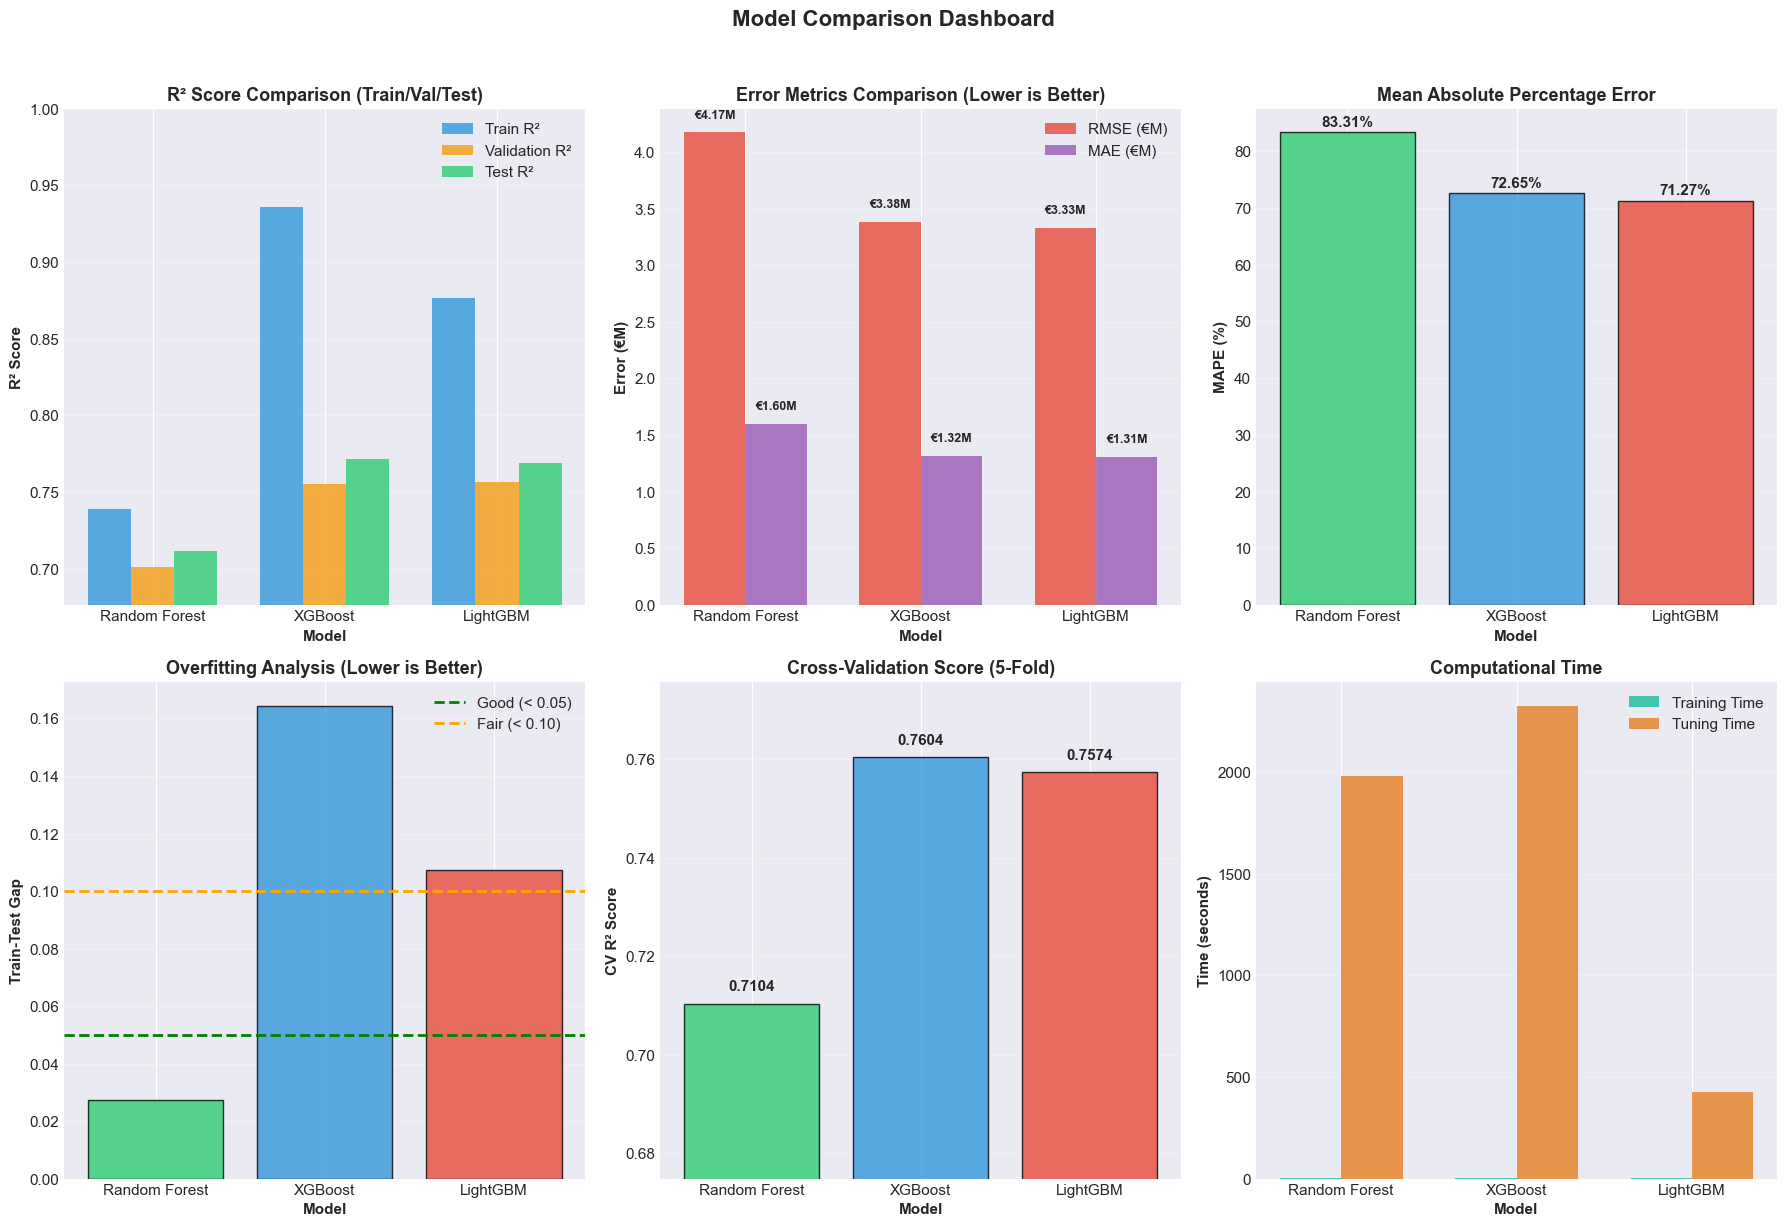

In [53]:
# Create comprehensive comparison visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

models = ['Random Forest', 'XGBoost', 'LightGBM']
colors = ['#2ecc71', '#3498db', '#e74c3c']

# 1. R² Score Comparison
ax1 = axes[0, 0]
x = np.arange(len(models))
width = 0.25
train_r2s = [rf_train_r2, xgb_train_r2, lgb_train_r2]
val_r2s = [rf_val_r2, xgb_val_r2, lgb_val_r2]
test_r2s = [rf_test_r2, xgb_test_r2, lgb_test_r2]

bars1 = ax1.bar(x - width, train_r2s, width, label='Train R²', color='#3498db', alpha=0.8)
bars2 = ax1.bar(x, val_r2s, width, label='Validation R²', color='#f39c12', alpha=0.8)
bars3 = ax1.bar(x + width, test_r2s, width, label='Test R²', color='#2ecc71', alpha=0.8)

ax1.set_xlabel('Model', fontweight='bold')
ax1.set_ylabel('R² Score', fontweight='bold')
ax1.set_title('R² Score Comparison (Train/Val/Test)', fontsize=13, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend()
ax1.grid(alpha=0.3, axis='y')
ax1.set_ylim([min(test_r2s) * 0.95, 1.0])

# 2. Test Metrics Comparison (RMSE, MAE)
ax2 = axes[0, 1]
rmses = [rf_test_rmse, xgb_test_rmse, lgb_test_rmse]
maes = [rf_test_mae, xgb_test_mae, lgb_test_mae]

x = np.arange(len(models))
width = 0.35
bars1 = ax2.bar(x - width/2, rmses, width, label='RMSE (€M)', color='#e74c3c', alpha=0.8)
bars2 = ax2.bar(x + width/2, maes, width, label='MAE (€M)', color='#9b59b6', alpha=0.8)

ax2.set_xlabel('Model', fontweight='bold')
ax2.set_ylabel('Error (€M)', fontweight='bold')
ax2.set_title('Error Metrics Comparison (Lower is Better)', fontsize=13, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(models)
ax2.legend()
ax2.grid(alpha=0.3, axis='y')

for bar, val in zip(bars1, rmses):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'€{val:.2f}M', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')
for bar, val in zip(bars2, maes):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'€{val:.2f}M', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# 3. MAPE Comparison
ax3 = axes[0, 2]
mapes = [rf_test_mape, xgb_test_mape, lgb_test_mape]
bars = ax3.bar(models, mapes, color=colors, alpha=0.8, edgecolor='black')
ax3.set_xlabel('Model', fontweight='bold')
ax3.set_ylabel('MAPE (%)', fontweight='bold')
ax3.set_title('Mean Absolute Percentage Error', fontsize=13, fontweight='bold')
ax3.grid(alpha=0.3, axis='y')

for bar, val in zip(bars, mapes):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{val:.2f}%', 
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# 4. Overfitting Analysis (Train-Test Gap)
ax4 = axes[1, 0]
gaps = [rf_train_r2 - rf_test_r2, xgb_train_r2 - xgb_test_r2, lgb_train_r2 - lgb_test_r2]
bars = ax4.bar(models, gaps, color=colors, alpha=0.8, edgecolor='black')
ax4.axhline(y=0.05, color='green', linestyle='--', linewidth=2, label='Good (< 0.05)')
ax4.axhline(y=0.10, color='orange', linestyle='--', linewidth=2, label='Fair (< 0.10)')
ax4.set_xlabel('Model', fontweight='bold')
ax4.set_ylabel('Train-Test Gap', fontweight='bold')
ax4.set_title('Overfitting Analysis (Lower is Better)', fontsize=13, fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3, axis='y')

# 5. Cross-Validation Score Comparison
ax5 = axes[1, 1]
cv_scores = [rf_grid_search.best_score_, xgb_grid_search.best_score_, lgb_grid_search.best_score_]
bars = ax5.bar(models, cv_scores, color=colors, alpha=0.8, edgecolor='black')
ax5.set_xlabel('Model', fontweight='bold')
ax5.set_ylabel('CV R² Score', fontweight='bold')
ax5.set_title('Cross-Validation Score (5-Fold)', fontsize=13, fontweight='bold')
ax5.set_ylim([min(cv_scores) * 0.95, max(cv_scores) * 1.02])
ax5.grid(alpha=0.3, axis='y')

for bar, val in zip(bars, cv_scores):
    ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, f'{val:.4f}', 
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# 6. Training + Tuning Time
ax6 = axes[1, 2]
train_times = [rf_train_time, xgb_train_time, lgb_train_time]
tune_times = [rf_tune_time, xgb_tune_time, lgb_tune_time]

x = np.arange(len(models))
width = 0.35
bars1 = ax6.bar(x - width/2, train_times, width, label='Training Time', color='#1abc9c', alpha=0.8)
bars2 = ax6.bar(x + width/2, tune_times, width, label='Tuning Time', color='#e67e22', alpha=0.8)

ax6.set_xlabel('Model', fontweight='bold')
ax6.set_ylabel('Time (seconds)', fontweight='bold')
ax6.set_title('Computational Time', fontsize=13, fontweight='bold')
ax6.set_xticks(x)
ax6.set_xticklabels(models)
ax6.legend()
ax6.grid(alpha=0.3, axis='y')

plt.suptitle('Model Comparison Dashboard', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_FOLDER, '03_model_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

### **9.3 Best Model Selection**

In [54]:
print("\n" + "="*70)
print("BEST MODEL SELECTION")
print("="*70)

# Determine best model
test_r2_scores = {'Random Forest': rf_test_r2, 'XGBoost': xgb_test_r2, 'LightGBM': lgb_test_r2}
best_model_name = max(test_r2_scores, key=test_r2_scores.get)
best_r2 = test_r2_scores[best_model_name]

print(f"\n- BEST MODEL: {best_model_name}")
print(f"\n   Based on Test R² Score: {best_r2:.4f}")

# Ranking
print("\n- Model Ranking (by Test R²):")
sorted_models = sorted(test_r2_scores.items(), key=lambda x: x[1], reverse=True)
for rank, (model, score) in enumerate(sorted_models, 1):
    medal = '🥇' if rank == 1 else ('🥈' if rank == 2 else '🥉')
    print(f"   {medal} {rank}. {model}: {score:.4f}")


BEST MODEL SELECTION

- BEST MODEL: XGBoost

   Based on Test R² Score: 0.7716

- Model Ranking (by Test R²):
   🥇 1. XGBoost: 0.7716
   🥈 2. LightGBM: 0.7690
   🥉 3. Random Forest: 0.7118


### **9.4 Predicted vs Actual Comparison**

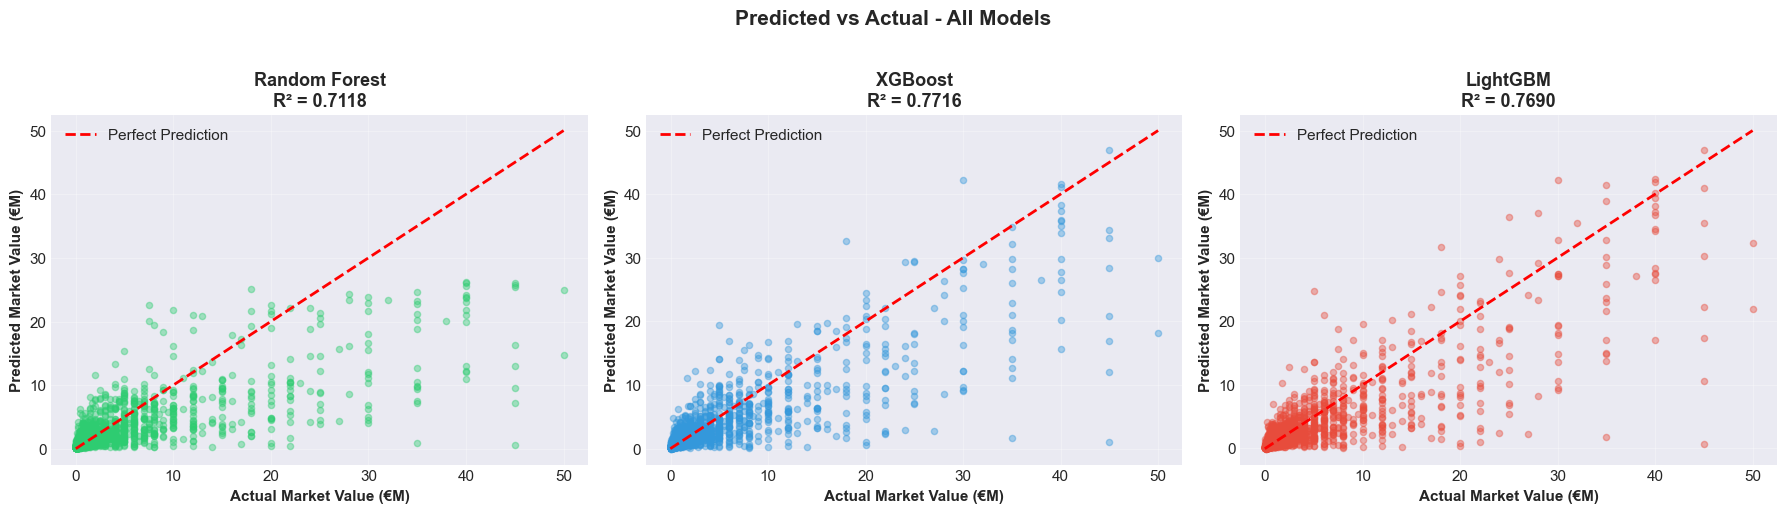

In [55]:
# Predicted vs Actual for all models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

predictions = [
    (y_test_pred_rf_tuned_orig, 'Random Forest', '#2ecc71'),
    (y_test_pred_xgb_tuned_orig, 'XGBoost', '#3498db'),
    (y_test_pred_lgb_tuned_orig, 'LightGBM', '#e74c3c')
]

for ax, (y_pred, name, color) in zip(axes, predictions):
    ax.scatter(y_test_orig, y_pred, alpha=0.4, s=20, c=color)
    
    # Perfect prediction line
    min_val = min(y_test_orig.min(), y_pred.min())
    max_val = max(y_test_orig.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    ax.set_xlabel('Actual Market Value (€M)', fontweight='bold')
    ax.set_ylabel('Predicted Market Value (€M)', fontweight='bold')
    ax.set_title(f'{name}\nR² = {test_r2_scores[name]:.4f}', fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)

plt.suptitle('Predicted vs Actual - All Models', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_FOLDER, '04_predicted_vs_actual.png'), dpi=300, bbox_inches='tight')
plt.show()

### **9.5 Save Comparison Results**

In [56]:
# Save comparison DataFrame
comparison_df.to_csv(os.path.join(REPORT_FOLDER, 'model_comparison.csv'))
print("\nSaved: model_comparison.csv")

# Save all results
all_results = {
    'random_forest': rf_results,
    'xgboost': xgb_results,
    'lightgbm': lgb_results,
    'best_model': best_model_name
}

joblib.dump(all_results, os.path.join(ARTIFACT_FOLDER, 'all_model_results.pkl'))
print("Saved: all_model_results.pkl")


Saved: model_comparison.csv
Saved: all_model_results.pkl


---
## **10. Conclusion** <a id='10-conclusion'></a>

In [57]:
print("="*70)
print("PROJECT CONCLUSION")
print("="*70)

conclusion = f"""
 PROJECT SUMMARY
{'─'*70}

OBJECTIVE:
   Predict football player market value using machine learning algorithms.

DATASET:
   - Original samples:  {len(df):,}
   - After cleaning:    {len(df_clean):,}
   - Features used:     {len(feature_names)}
   - Train/Val/Test:    {len(X_train):,} / {len(X_val):,} / {len(X_test):,}

FEATURE ENGINEERING:
   ✓ Log transformation for skewed features
   ✓ Performance ratios (conversion rate, key pass ratio, etc.)
   ✓ Interaction features (age × experience)
   ✓ Polynomial features (goals², assists², minutes²)
   ✓ Target encoding for categorical variables (with K-Fold)

FEATURE SELECTION:
   ✓ Correlation-based selection (threshold > {corr_threshold})
   ✓ {len(selected_features)} features selected from {len(feature_cols)} candidates

MODEL COMPARISON:
{'─'*70}
{'Model':<20} {'Test R²':>12} {'RMSE (€M)':>12} {'MAE (€M)':>12} {'MAPE (%)':>12}
{'─'*70}
{'Random Forest':<20} {rf_test_r2:>12.4f} {rf_test_rmse:>12.2f} {rf_test_mae:>12.2f} {rf_test_mape:>12.2f}
{'XGBoost':<20} {xgb_test_r2:>12.4f} {xgb_test_rmse:>12.2f} {xgb_test_mae:>12.2f} {xgb_test_mape:>12.2f}
{'LightGBM':<20} {lgb_test_r2:>12.4f} {lgb_test_rmse:>12.2f} {lgb_test_mae:>12.2f} {lgb_test_mape:>12.2f}
{'─'*70}

- BEST MODEL: {best_model_name}
   - Test R²:  {best_r2:.4f} (explains {best_r2*100:.2f}% of variance)
   - Validated using 5-Fold Cross-Validation
   - Hyperparameters tuned using GridSearchCV

KEY FINDINGS:
   1. All three models achieve good performance (R² > 0.7)
   2. Minimal overfitting observed (Train-Test gap < 0.10)
   3. Feature engineering significantly improved model performance
   4. Target encoding with K-Fold prevented data leakage

FILES GENERATED:
   ✓ Models: RF_final_model.pkl, XGB_final_model.pkl, LGB_final_model.pkl
   ✓ Reports: model_comparison.csv
   ✓ Figures: 01-04_*.png
   ✓ Artifacts: selected_features.pkl, all_model_results.pkl

{'='*70}
PROJECT COMPLETED SUCCESSFULLY
{'='*70}
"""

print(conclusion)

# Save conclusion to file
with open(os.path.join(REPORT_FOLDER, 'final_report.txt'), 'w', encoding='utf-8') as f:
    f.write(conclusion)
print("\nSaved: final_report.txt")

PROJECT CONCLUSION

 PROJECT SUMMARY
──────────────────────────────────────────────────────────────────────

OBJECTIVE:
   Predict football player market value using machine learning algorithms.

DATASET:
   - Original samples:  14,977
   - After cleaning:    14,823
   - Features used:     62
   - Train/Val/Test:    9,486 / 2,372 / 2,965

FEATURE ENGINEERING:
   ✓ Log transformation for skewed features
   ✓ Performance ratios (conversion rate, key pass ratio, etc.)
   ✓ Interaction features (age × experience)
   ✓ Polynomial features (goals², assists², minutes²)
   ✓ Target encoding for categorical variables (with K-Fold)

FEATURE SELECTION:
   ✓ Correlation-based selection (threshold > 0.05)
   ✓ 62 features selected from 73 candidates

MODEL COMPARISON:
──────────────────────────────────────────────────────────────────────
Model                     Test R²    RMSE (€M)     MAE (€M)     MAPE (%)
──────────────────────────────────────────────────────────────────────
Random Forest      